# Get GEE ready

In [17]:
# Earth Engine Python APIのインポート
import ee
# GEEの認証・初期化
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g7366YswCoK4BVOJ58zdIloGHdJj9m6CNfafhNSJYz6sq2xLJCwEG8

Successfully saved authorization token.


# Import

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta
import netCDF4
from scipy import interpolate

# Set up functions and params

In [19]:
def date_range(start, stop, step = timedelta(1)):
    current = start
    while current < stop:
        yield current
        current += step

In [86]:
params = {'lon_min': 140.2,
         'lon_max': 141.2,
          'lat_min': 35.3,
          'lat_max': 36.3,
          'gridwidth': 0.25,
          'gravity': 9.8,
          'sea_density': 1.023, #t/m^3
          'area': 1000, #m^2
         }

# Get wind data

In [51]:
# Area of Interest 
aoi = ee.Geometry.Polygon(
  [[[params['lon_min'], params['lat_min']],
    [params['lon_min'], params['lat_max']],
    [params['lon_max'], params['lat_max']],
    [params['lon_max'], params['lat_min']]]], None, False)

In [76]:
img_col = ee.ImageCollection("ECMWF/ERA5/DAILY") \
                    .select(['u_component_of_wind_10m', 'v_component_of_wind_10m']) \
                    .filter(ee.Filter.date('2020-01-01', '2020-12-31'))

In [77]:
index_num=0
tent_np_array_u = np.zeros((5, 5))
tent_np_array_v = np.zeros((5, 5))
date_start=date(2020, 1, 1)
date_end=date(2020, 6, 30)

In [78]:
for d in date_range(date_start, date_end):
    if index_num % 20 == 1:
        print('Loading data on {} now'.format(d))
    img_date = img_col.filter(ee.Filter.date('{}'.format(d))).first()
    band_arrs = img_date.sampleRectangle(region=aoi)
    band_arr_u = band_arrs.get('u_component_of_wind_10m')
    band_arr_v = band_arrs.get('v_component_of_wind_10m')
    np_arr_u = np.array(band_arr_u.getInfo())
    np_arr_v = np.array(band_arr_v.getInfo())
    tent_np_array_u += np_arr_u
    tent_np_array_v += np_arr_v
    index_num += 1
print('index_num is: {}'.format(index_num))

Loading data on 2020-01-02 now
Loading data on 2020-01-22 now
Loading data on 2020-02-11 now
Loading data on 2020-03-02 now
Loading data on 2020-03-22 now
Loading data on 2020-04-11 now
Loading data on 2020-05-01 now
Loading data on 2020-05-21 now
Loading data on 2020-06-10 now
index_num is: 181


In [79]:
year_ave_wind_u=tent_np_array_u/index_num
year_ave_wind_v=tent_np_array_v/index_num

# Get wave data

In [13]:
filename=\
'/Users/taniguchikentaro/Documents/projects/Tide_energy/global-analysis-forecast-wav-001-027_1615346002999.nc'
nc = netCDF4.Dataset(filename, 'r')

wave_height = nc.variables['VHM0_WW'][:]
wave_direction = nc.variables['VMDR'][:]

tent_height = np.zeros((13, 13))
tent_direction = np.zeros((13, 13))

for i in range(wave_height.shape[0]):
    tent_height += wave_height[i]
    tent_direction += wave_direction[i]

tent_height = np.where(tent_height < 1, 0, tent_height)
tent_direction = np.where(tent_direction < 1, 0, tent_direction)
    
year_ave_height = tent_height/wave_height.shape[0]
year_ave_direction = tent_direction/wave_direction.shape[0]

# Get tide data

In [88]:
def get_height(filename):
    
    names = ['year', 'month', 'date', 'loc', 'h1_t', 'h1_h', 'h2_t', 'h2_h', 'h3_t', 'h3_h', 'h4_t', 'h4_h', 'l1_t', 'l1_h', 'l2_t', 'l2_h', 'l3_t', 'l3_h', 'l4_t', 'l4_h']
    df = pd.read_csv(filename, names=names)

    #干潮満潮がない場合を排除する
    df = df.replace([999, 9999], np.nan)

    height_01=df['h1_h']-df['l1_h']
    height_02=df['h2_h']-df['l2_h']
    height_ave=(height_01.mean()+height_02.mean())/2
    height_sum=(height_01.sum()+height_02.sum())*0.01
    return height_ave, height_sum

In [97]:
filename1='Choshi_2020.csv'
filename2='Kashima_2020.csv'

h_ave_Choshi, h_sum_Choshi = get_height(filename1)
h_ave_Kashima, h_sum_Kashima = get_height(filename2)

h_ave_Choshi = round(h_ave_Choshi, 2)
h_ave_Kashima = round(h_ave_Kashima, 2)

print('At Choshi, height ave is {} cm, height sum is {} m' \
      .format(h_ave_Choshi, h_sum_Choshi))
print('At Kashima, height ave is {} cm, height sum is {} m' \
      .format(h_ave_Kashima, h_sum_Kashima))

At Choshi, height ave is 71.23 cm, height sum is 476.13 m
At Kashima, height ave is 72.31 cm, height sum is 482.97 m


# Plot a map

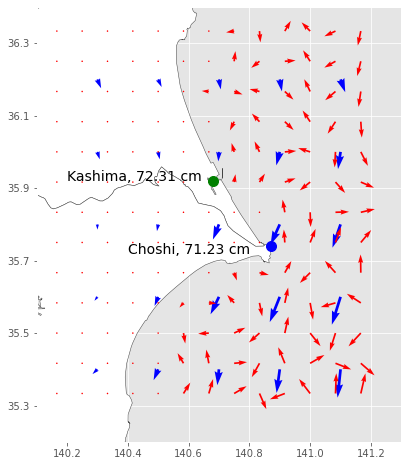

In [104]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


df = gpd.read_file('/Users/taniguchikentaro/Documents/projects/Tide_energy/land-master/japan.geojson')

# Create map basis with map
with plt.style.context("ggplot"):
    df.plot(figsize=(8,8), edgecolor='#444', facecolor='white', linewidth = 0.5);
    plt.xlim([params['lon_min']-0.1,params['lon_max']+0.1])
    plt.ylim([params['lat_min']-0.1,params['lat_max']+0.1])
    plt.xticks(np.linspace(params['lon_min'], params['lon_max'], num=6))
    plt.yticks(np.linspace(params['lat_min'], params['lat_max'], num=6))

#Set x and y ticks centers for wind vectors
xticks_grid=np.linspace(params['lon_min'], params['lon_max'], num=6)
yticks_grid=np.linspace(params['lat_min'], params['lat_max'], num=6)
xticks_center=(xticks_grid[:-1]+xticks_grid[1:])/2
yticks_center=(yticks_grid[:-1]+yticks_grid[1:])/2
gridwidth=(params['lon_max']-params['lon_min'])/5

#create mesh for wind vectors
X_wind, Y_wind= np.meshgrid(xticks_center, yticks_center)
plt.quiver(X_wind, Y_wind, year_ave_wind_u, year_ave_wind_v, color='blue',angles='xy',scale_units='xy', scale=20)

#create mesh for wave vectors
X_wave, Y_wave = np.meshgrid(longitude, latitude)
u_wave=year_ave_height*np.cos(year_ave_direction)
v_wave=year_ave_height*np.sin(year_ave_direction)
plt.quiver(X_wave, Y_wave, u_wave, v_wave,color='red',angles='xy',scale_units='xy', scale=15)

#Plot Tide energy data and measurement points
plt.text(140.40,35.72, 'Choshi, {} cm'.format(h_ave_Choshi), fontsize=14)
plt.plot(140.87,35.74, marker='o', color='blue', markersize=10)
plt.text(140.20,35.92, 'Kashima, {} cm'.format(h_ave_Kashima), fontsize=14)
plt.plot(140.68,35.92, marker='o', color='green', markersize=10)

plt.show()

# Compare results

In [121]:
#set a check point
long = 140.8
lat = 35.92

In [122]:
f_wave = interpolate.interp2d(X_wave, Y_wave, year_ave_height)
wave_height_here = round(f_wave(long, lat)[0], 2)
print('Wave height is {} m at a specified point'.format(wave_height_here))

Wave height is 0.4 m at the specified point


In [124]:
year_ave_wind_mag = (year_ave_wind_u**2+year_ave_wind_v**2)**0.5
f_wind = interpolate.interp2d(X_wind, Y_wind, year_ave_wind_mag)
wind_mag_here = round(f_wind(long, lat)[0], 2)
print('Wind magnitude is {} m/s at a specified point'.format(wind_mag_here))

Wind magnitude is 0.78 m/s at a specified point
